In [12]:
! pip install pymoo pyswarm openpyxl scikit-learn matplotlib seaborn torch pandas numpy

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pyswarm import pso
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from scipy import stats
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [14]:
def load_data(data_path):
    """
    Load data file (CSV or Excel) without time-series specific processing.
    Handles both .csv and .xlsx extensions.
    """
    if data_path.endswith('.csv'):
        return pd.read_csv(data_path, encoding='latin1')
    else:
        return pd.read_excel(data_path, engine='openpyxl')

def load_and_preprocess_data(data_path, aspect_ratio_value=None, test_ratio=0.2, seq_length=10):
    """
    Enhanced data loading and preprocessing with comprehensive validation.
    aspect_ratio_value: The actual aspect ratio value (0.3, 0.4, 0.5) to use as a feature
    """
    try:
        # 1. Data Loading with Validation
        data = load_data(data_path)

        # Validate expected columns
        expected_columns = {
            'time': 'Time index',
            'aspect_ratio': 'Geometry parameter',
            'liquid_frac': 'Phase change progress',
            'Nu': 'Nusselt number',
            'T_pcm': 'PCM temperature',
            'T_battery': 'Battery temperature (target)'
        }

        # Check for missing critical columns
        missing_cols = [col for col in expected_columns if col.lower() not in [c.lower() for c in data.columns]]
        if missing_cols:
            available_cols = "\n- " + "\n- ".join(data.columns)
            raise ValueError(
                f"Missing {len(missing_cols)} critical column(s) in {data_path}:\n"
                f"Missing: {missing_cols}\n"
                f"Available columns:{available_cols}"
            )

        # 2. Data Quality Checks
        if data.isnull().sum().sum() > 0:
            null_cols = data.columns[data.isnull().any()].tolist()
            raise ValueError(f"Null values found in columns: {null_cols}")

        # Ensure 'time' column is numeric or convertible
        if not pd.api.types.is_numeric_dtype(data['time']):
            try:
                data['time'] = pd.to_numeric(data['time'])
            except:
                raise ValueError("Time column must be convertible to numeric")

        # 3. Core Processing (for time-series data)
        data = data.sort_values('time')

        # Enhanced rolling mean with dynamic window for 'liquid_frac'
        window_size = min(5, len(data)//10)
        data['liquid_frac_rolling'] = (
            data['liquid_frac']
            .rolling(window=window_size, min_periods=1, center=True)
            .mean()
        )

        # 4. Train-Test Split with Temporal Preservation
        split_idx = int(len(data) * (1 - test_ratio))
        train_data = data.iloc[:split_idx]
        test_data = data.iloc[split_idx:]

        # 5. Sequence Creation with Safety Checks
        def create_sequences(df):
            sequences, targets = [], []
            # Use the actual column names from your data
            features = ['aspect_ratio', 'liquid_frac', 'Nu', 'T_pcm', 'liquid_frac_rolling']
            
            # Verify all feature columns exist in the DataFrame
            missing_features = [f for f in features if f not in df.columns]
            if missing_features:
                raise ValueError(f"Missing features: {missing_features}")

            # Create sequences of input features and corresponding target values
            for i in range(len(df) - seq_length):
                seq = df.iloc[i:i+seq_length]
                sequences.append(seq[features].values)
                targets.append(seq['T_battery'].iloc[-1])

            # Ensure sequences were created successfully
            if not sequences:
                raise ValueError(
                    f"Insufficient data for sequence length {seq_length}. "
                    f"Available: {len(df)} samples"
                )

            return np.array(sequences), np.array(targets).reshape(-1, 1)

        X_train, y_train = create_sequences(train_data)
        X_test, y_test = create_sequences(test_data)

    except Exception as e:
        print(f"\n{' ERROR ':-^60}")
        print(f"Failed processing {data_path}")
        print(f"Error: {str(e)}")
        print(f"\nDebugging Info:")
        if 'data' in locals():
            print(f"- Shape: {data.shape}")
            print(f"- Columns: {data.columns.tolist()}")
            if 'time' in data.columns:
                print(f"- Time range: {data['time'].min()} to {data['time'].max()}")
        print('-'*60)
        raise

    # 6. Smart Normalization
    def normalize(X, y):
        """
        Handles edge cases in normalization (e.g., constant columns).
        Calculates mean and standard deviation for X and y separately.
        """
        # Calculate mean and std for X. Handle 3D (sequences) or 2D (single samples)
        X_mean = np.nanmean(X, axis=(0, 1)) if X.ndim == 3 else np.nanmean(X, axis=0)
        X_std = np.nanstd(X, axis=(0, 1)) if X.ndim == 3 else np.nanstd(X, axis=0)

        # Handle cases where std is zero (constant features) to avoid division by zero
        X_std[X_std == 0] = 1

        # Calculate mean and std for y (targets)
        y_mean, y_std = np.nanmean(y), np.nanstd(y)
        # Handle constant targets
        y_std = 1 if y_std == 0 else y_std

        # Apply normalization
        X_norm = (X - X_mean) / (X_std + 1e-8)
        y_norm = (y - y_mean) / (y_std + 1e-8)

        return X_norm, y_norm, (X_mean, X_std, y_mean, y_std)

    # Normalize training data to get statistics, then apply to test data
    X_train_norm, y_train_norm, norm_stats = normalize(X_train, y_train)
    X_test_norm, y_test_norm, _ = normalize(X_test, y_test)

    return X_train_norm, X_test_norm, y_train_norm, y_test_norm, norm_stats

def augment_data(X, y, norm_stats, noise_factor=0.01, temp_threshold=70):
    """
    Enhanced data augmentation with temperature-based oversampling.
    Adds noise and oversamples high-temperature instances to improve model
    performance in critical regions.
    """
    # Denormalize y to actual temperatures using provided norm_stats
    y_actual = y * norm_stats[3] + norm_stats[2]

    # Add standard noise to X (features)
    X_noisy = X + noise_factor * np.random.randn(*X.shape)
    y_noisy = y.copy()

    # Oversample high-temperature cases
    high_temp_idx = np.where(y_actual > temp_threshold)[0]
    if len(high_temp_idx) > 0:
        X_high = X[high_temp_idx]
        y_high = y[high_temp_idx]

        # Create extra noisy versions of high-temp samples (3x oversampling)
        for _ in range(3):
            X_high_noisy = X_high + (noise_factor*2) * np.random.randn(*X_high.shape)
            X_noisy = np.vstack([X_noisy, X_high_noisy])
            y_noisy = np.vstack([y_noisy, y_high])

    # Combine original and augmented data
    return np.vstack([X, X_noisy]), np.vstack([y, y_noisy])

In [15]:
class EnhancedPINN(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout_rate=0.4):
        super(EnhancedPINN, self).__init__()
        
        # Main LSTM layer for sequential data processing
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=dropout_rate
        )
        
        # Auxiliary branch for high-temperature features
        self.high_temp_branch = nn.Sequential(
            nn.Linear(input_size * 10, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16)
        )
        
        # Enhanced prediction head
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + 16, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1)
        )
        
        # Initialize weights properly
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """Proper weight initialization for better training"""
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)
                elif 'bias' in name:
                    nn.init.constant_(param, 0)
    
    def forward(self, x):
        """
        Forward pass through the network
        x: input tensor of shape (batch_size, seq_length, input_size)
        returns: prediction tensor of shape (batch_size, 1)
        """
        # Handle single sample inference
        if x.dim() == 2:
            x = x.unsqueeze(0)  # Add batch dimension: (seq_length, input_size) -> (1, seq_length, input_size)
        
        # Process through main LSTM branch
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, seq_length, hidden_size)
        lstm_last = lstm_out[:, -1, :]  # Take last time step: (batch_size, hidden_size)
        
        # Process through auxiliary branch
        batch_size = x.size(0)
        flat_seq = x.reshape(batch_size, -1)  # Flatten: (batch_size, seq_length * input_size)
        aux_out = self.high_temp_branch(flat_seq)  # aux_out shape: (batch_size, 16)
        
        # Combine features from both branches
        combined = torch.cat([lstm_last, aux_out], dim=1)  # combined shape: (batch_size, hidden_size + 16)
        
        # Final prediction
        return self.fc(combined)  # output shape: (batch_size, 1)

In [16]:
class TemperatureWeightedMSELoss(nn.Module):
    def __init__(self, norm_stats, threshold=70.0, weight_factor=5.0):
        super().__init__()
        self.register_buffer('y_mean', torch.tensor(norm_stats[2], dtype=torch.float32))
        self.register_buffer('y_std', torch.tensor(norm_stats[3], dtype=torch.float32))
        self.threshold = threshold
        self.weight_factor = weight_factor

    def forward(self, pred, target):
        pred_actual = pred * self.y_std + self.y_mean
        target_actual = target * self.y_std + self.y_mean

        base_loss = F.mse_loss(pred, target)

        weights = torch.ones_like(target_actual)
        above_threshold = target_actual > self.threshold
        weights[above_threshold] = self.weight_factor

        weighted_loss = (weights * (pred - target)**2).mean()
        return 0.7 * weighted_loss + 0.3 * base_loss

In [17]:
class BatteryCoolingProblem(Problem):
    def __init__(self, model, X_train, y_train):
        super().__init__(n_var=3, n_obj=2, n_constr=1,
                         xl=np.array([0.1, 1000, 0.1]),
                         xu=np.array([0.9, 2000, 0.9]))
        self.model = model
        self.X_train = X_train
        self.y_train = y_train

    def _evaluate(self, x, out, *args, **kwargs):
        x = x.reshape(-1, 3)
        liquid_frac, Nu, T_pcm = x[:, 0], x[:, 1], x[:, 2]
        
        # Physics-based equations
        heat_transfer_coeff = 0.8 * liquid_frac + 0.2
        cooling_effect = Nu * heat_transfer_coeff / 1000
        temps = T_pcm - cooling_effect * (T_pcm - 25)
        
        critical_temp = 90
        safety_margins = critical_temp - temps
        
        vortex_constraint = 0.5 - liquid_frac
        
        out["F"] = np.column_stack([temps, -safety_margins])
        out["G"] = vortex_constraint

In [18]:
def validate_dataset(data_path):
    try:
        if data_path.endswith('.csv'):
            data = pd.read_csv(data_path, encoding='latin1', nrows=1)
        else:
            data = pd.read_excel(data_path, engine='openpyxl', nrows=1)

        critical_cols = ['time', 'T_battery']
        missing = [col for col in critical_cols if col not in data.columns]
        if missing:
            raise ValueError(f"Missing critical columns: {missing}")

        if data_path.endswith('.csv'):
            temp_data = pd.read_csv(data_path, usecols=['T_battery'], encoding='latin1')
        else:
            temp_data = pd.read_excel(data_path, usecols=['T_battery'], engine='openpyxl')
            
        if temp_data['T_battery'].nunique() < 2:
            raise ValueError("Target column 'T_battery' has no variability")

        return True
    except Exception as e:
        print(f"Validation failed for {data_path}: {str(e)}")
        return False

def safe_load_dataset(path, aspect_ratio, max_retries=2):
    for attempt in range(max_retries):
        try:
            if not validate_dataset(path):
                raise ValueError("Initial validation failed")
            result = load_and_preprocess_data(path)
            print(f"✔ Successfully loaded {aspect_ratio} data")
            return result
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"✖ Failed to load {aspect_ratio} after {max_retries} attempts")
                return None
            print(f"! Retrying {aspect_ratio} (attempt {attempt + 1})...")

# Load all datasets
dataset_paths = {
    '0.3': '0.3.xlsx',
    '0.4': '0.4.xlsx', 
    '0.5': '0.5.xlsx'
}

datasets = {}
for ar, path in dataset_paths.items():
    datasets[ar] = safe_load_dataset(path, ar)

datasets = {k: v for k, v in datasets.items() if v is not None}

if not datasets:
    raise RuntimeError("No datasets loaded successfully.")

print("\n🔄 COMBINING DATA FROM ALL ASPECT RATIOS FOR TRAINING")

# Combine all training data
all_X_train, all_X_test, all_y_train, all_y_test = [], [], [], []

for ar, (X_train, X_test, y_train, y_test, norm_stats) in datasets.items():
    all_X_train.append(X_train)
    all_X_test.append(X_test)
    all_y_train.append(y_train)
    all_y_test.append(y_test)
    print(f"Added {X_train.shape[0]} samples from aspect ratio {ar}")

X_train_combined = np.vstack(all_X_train)
X_test_combined = np.vstack(all_X_test)
y_train_combined = np.vstack(all_y_train)
y_test_combined = np.vstack(all_y_test)

print(f"\n📊 Combined Dataset:")
print(f"Training: {X_train_combined.shape[0]} sequences")
print(f"Testing: {X_test_combined.shape[0]} sequences")

# Use first dataset's normalization stats
norm_stats = datasets['0.3'][4]

# Initialize model with COMBINED data
model = EnhancedPINN(input_size=X_train_combined.shape[-1]).to(device)
criterion = TemperatureWeightedMSELoss(norm_stats, threshold=70.0, weight_factor=5.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.15)  # Increased weight decay
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=8, factor=0.5)

# Prepare training data
train_dataset = TensorDataset(
    torch.tensor(X_train_combined, dtype=torch.float32).to(device),
    torch.tensor(y_train_combined, dtype=torch.float32).to(device)
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Validation data (use combined test data)
X_val = torch.tensor(X_test_combined[:2000], dtype=torch.float32).to(device)
y_val = torch.tensor(y_test_combined[:2000], dtype=torch.float32).to(device)

✔ Successfully loaded 0.3 data
✔ Successfully loaded 0.4 data
✔ Successfully loaded 0.5 data

🔄 COMBINING DATA FROM ALL ASPECT RATIOS FOR TRAINING
Added 19990 samples from aspect ratio 0.3
Added 21987 samples from aspect ratio 0.4
Added 19990 samples from aspect ratio 0.5

📊 Combined Dataset:
Training: 61967 sequences
Testing: 15470 sequences



                    TRAINING MODEL ON ASPECT RATIO 0.3 DATA                     
Starting training on cpu...
Epoch [10/150] - Train Loss: 0.1963, Val Loss: 0.0851, LR: 1.00e-03
Epoch [20/150] - Train Loss: 0.1886, Val Loss: 0.0550, LR: 5.00e-04
Epoch [30/150] - Train Loss: 0.1881, Val Loss: 0.0500, LR: 2.50e-04
🛑 Early stopping at epoch 33
Training completed in 328.17 seconds! Best model saved.


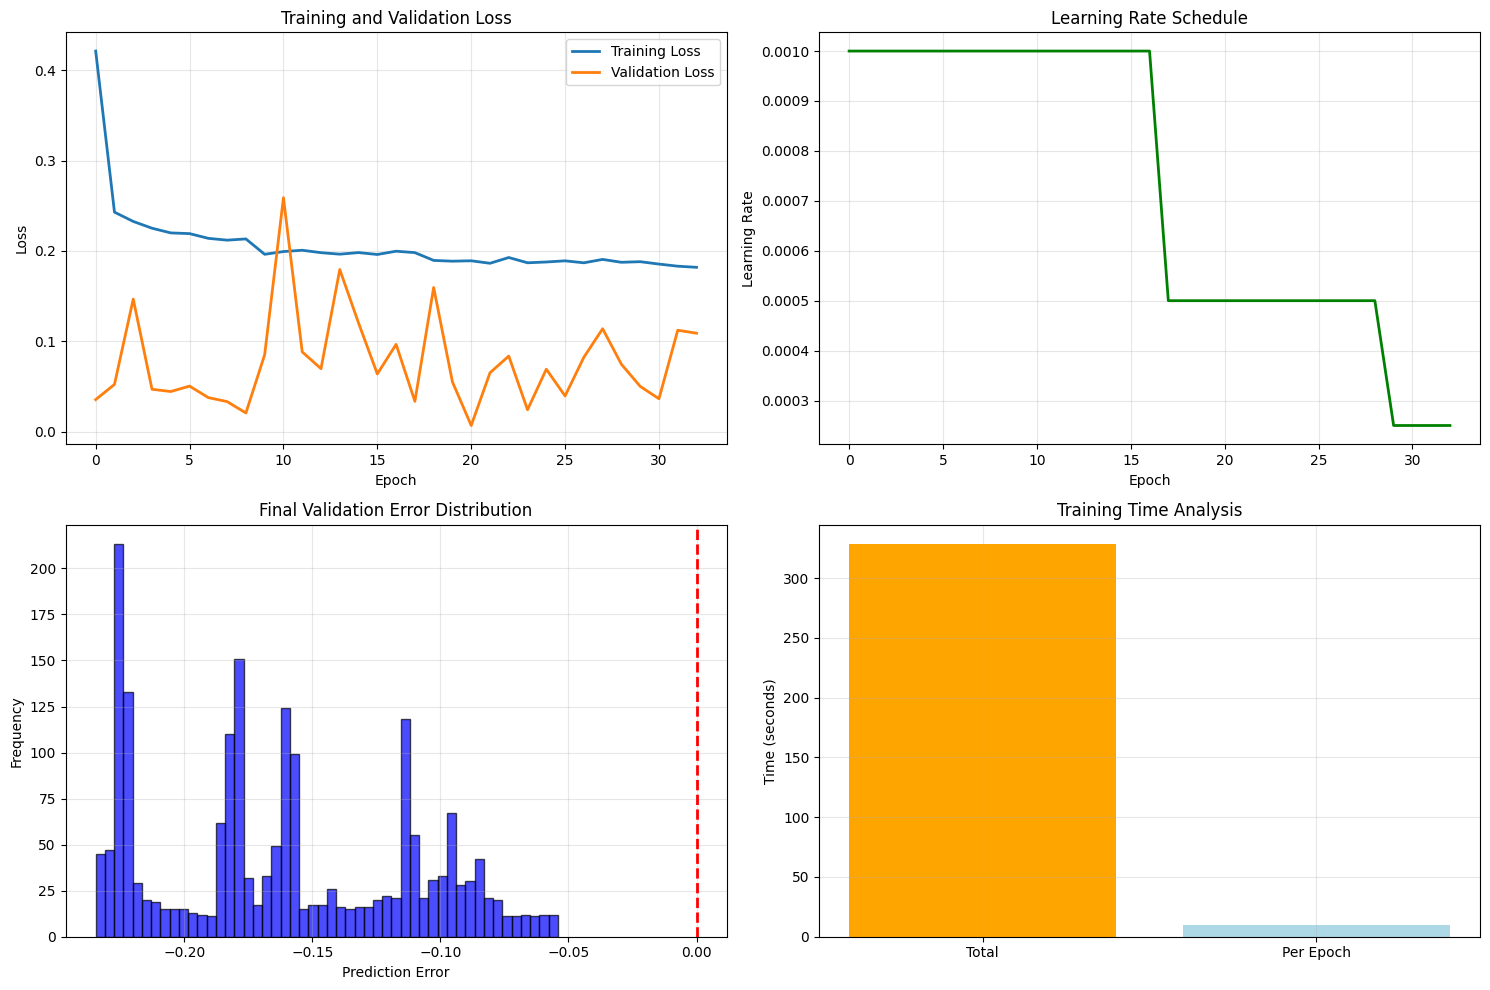

<All keys matched successfully>

In [19]:
def train_model_with_analysis(model, train_loader, X_val, y_val, criterion, optimizer, scheduler, epochs, device):
    train_losses = []
    val_losses = []
    learning_rates = []
    best_val_loss = float('inf')
    best_model = None
    patience = 12
    patience_counter = 0
    start_time = time.time()
    
    print(f"Starting training on {device}...")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val)
        
        scheduler.step(val_loss)
        
        # Store metrics
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss.item())
        learning_rates.append(optimizer.param_groups[0]['lr'])
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model = model.state_dict().copy()
            torch.save(best_model, 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"🛑 Early stopping at epoch {epoch+1}")
                break
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}] - '
                  f'Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'LR: {learning_rates[-1]:.2e}')
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds! Best model saved.")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses, 
        'learning_rates': learning_rates,
        'training_time': training_time,
        'best_val_loss': best_val_loss
    }

def plot_training_curves(training_history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    ax1.plot(training_history['train_losses'], label='Training Loss', linewidth=2)
    ax1.plot(training_history['val_losses'], label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(training_history['learning_rates'], color='green', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.grid(True, alpha=0.3)
    
    model.eval()
    with torch.no_grad():
        final_val_pred = model(X_val).cpu().numpy()
        final_val_true = y_val.cpu().numpy()
    errors = final_val_true - final_val_pred
    
    ax3.hist(errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Prediction Error')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Final Validation Error Distribution')
    ax3.grid(True, alpha=0.3)
    
    epochs = len(training_history['train_losses'])
    time_per_epoch = training_history['training_time'] / epochs
    ax4.bar(['Total', 'Per Epoch'], 
            [training_history['training_time'], time_per_epoch],
            color=['orange', 'lightblue'])
    ax4.set_ylabel('Time (seconds)')
    ax4.set_title('Training Time Analysis')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Train the model
print("\n" + "="*80)
print(" TRAINING MODEL ON ASPECT RATIO 0.3 DATA ".center(80))
print("="*80)

training_history = train_model_with_analysis(
    model, train_loader, X_val, y_val, criterion, optimizer, scheduler, 150, device
)

plot_training_curves(training_history)
model.load_state_dict(torch.load('best_model.pth'))

In [20]:
class ComprehensiveEvaluator:
    def __init__(self, norm_stats, thresholds=[65, 70, 75, 80]):
        self.norm_stats = norm_stats
        self.thresholds = thresholds
        self.y_mean, self.y_std = norm_stats[2], norm_stats[3]

    def denormalize(self, y_norm):
        return y_norm * self.y_std + self.y_mean

    def calculate_comprehensive_metrics(self, y_true_norm, y_pred_norm):
        y_true = self.denormalize(y_true_norm.flatten())
        y_pred = self.denormalize(y_pred_norm.flatten())

        metrics = {
            'regression': {},
            'classification': {},
            'distribution': {},
            'confusion_matrices': {}
        }

        # Regression Metrics
        metrics['regression']['mae'] = mean_absolute_error(y_true, y_pred)
        metrics['regression']['rmse'] = np.sqrt(mean_squared_error(y_true, y_pred))
        metrics['regression']['r2'] = r2_score(y_true, y_pred)
        metrics['regression']['max_error'] = np.max(np.abs(y_true - y_pred))

        # Error distribution statistics
        errors = y_true - y_pred
        metrics['distribution']['error_mean'] = np.mean(errors)
        metrics['distribution']['error_std'] = np.std(errors)
        metrics['distribution']['error_median'] = np.median(errors)
        metrics['distribution']['error_95p'] = np.percentile(np.abs(errors), 95)
        metrics['distribution']['error_skew'] = stats.skew(errors) if len(errors) > 1 else 0
        metrics['distribution']['error_kurtosis'] = stats.kurtosis(errors) if len(errors) > 1 else 0

        # Classification Metrics for each threshold
        for thresh in self.thresholds:
            y_true_class = (y_true > thresh).astype(int)
            y_pred_class = (y_pred > thresh).astype(int)

            # Only calculate if both classes are present
            if len(np.unique(y_true_class)) > 1 and len(y_true_class) > 0:
                try:
                    # Calculate all classification metrics
                    accuracy = accuracy_score(y_true_class, y_pred_class)
                    precision = precision_score(y_true_class, y_pred_class, zero_division=0)
                    recall = recall_score(y_true_class, y_pred_class, zero_division=0)
                    f1 = f1_score(y_true_class, y_pred_class, zero_division=0)
                    
                    # Confusion matrix components
                    tn, fp, fn, tp = confusion_matrix(y_true_class, y_pred_class).ravel()
                    
                    # Additional metrics
                    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
                    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
                    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
                    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

                    metrics['classification'][f'threshold_{thresh}'] = {
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1_score': f1,
                        'specificity': specificity,
                        'npv': npv,
                        'fpr': fpr,
                        'fnr': fnr,
                        'support': len(y_true_class),
                        'positive_ratio': np.mean(y_true_class),
                        'confusion_matrix': {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
                    }

                    # Store confusion matrix
                    metrics['confusion_matrices'][f'threshold_{thresh}'] = confusion_matrix(y_true_class, y_pred_class)

                except Exception as e:
                    print(f"Warning: Could not calculate metrics for threshold {thresh}: {e}")
            else:
                print(f"⚠️ Only one class present at {thresh}°C threshold - skipping classification metrics")

        return metrics

    def calculate_temperature_range_metrics(self, y_true, y_pred):
        ranges = [
            ('Normal (<70°C)', (0, 70)),
            ('Warning (70-90°C)', (70, 90)),
            ('Critical (90-180°C)', (90, 180)),
            ('Super Critical (180-280°C)', (180, 280)),
            ('Hyper Critical (>280°C)', (280, np.inf))
        ]

        range_metrics = {}
        extreme_samples = 0

        for name, (low, high) in ranges:
            if high == np.inf:
                mask = (y_true >= low)
            else:
                mask = (y_true >= low) & (y_true < high)

            if np.sum(mask) > 0:
                y_true_range = y_true[mask]
                y_pred_range = y_pred[mask]

                range_metrics[name] = {
                    'mae': mean_absolute_error(y_true_range, y_pred_range),
                    'rmse': np.sqrt(mean_squared_error(y_true_range, y_pred_range)),
                    'r2': r2_score(y_true_range, y_pred_range),
                    'max_error': np.max(np.abs(y_true_range - y_pred_range)),
                    'samples': np.sum(mask),
                    'avg_temp': np.mean(y_true_range)
                }

                if low >= 90:
                    extreme_samples += np.sum(mask)
            else:
                range_metrics[name] = {
                    'samples': 0,
                    'avg_temp': None,
                    'status': 'NO_DATA'
                }

        return range_metrics, extreme_samples

    def print_detailed_report(self, metrics, model_name, aspect_ratio):
        print(f"\n{'='*80}")
        print(f" COMPREHENSIVE EVALUATION: {model_name} (Aspect Ratio {aspect_ratio}) ")
        print(f"{'='*80}")

        print(f"\n📊 REGRESSION METRICS:")
        reg_metrics = metrics['regression']
        print(f"   MAE:          {reg_metrics['mae']:.4f} °C")
        print(f"   RMSE:         {reg_metrics['rmse']:.4f} °C")
        print(f"   R²:           {reg_metrics['r2']:.4f}")
        print(f"   Max Error:    {reg_metrics['max_error']:.4f} °C")

        print(f"\n📈 ERROR DISTRIBUTION:")
        dist_metrics = metrics['distribution']
        print(f"   Mean Error:    {dist_metrics['error_mean']:.4f} °C")
        print(f"   Std Error:     {dist_metrics['error_std']:.4f} °C")
        print(f"   Median Error:  {dist_metrics['error_median']:.4f} °C")
        print(f"   95th %ile:     {dist_metrics['error_95p']:.4f} °C")
        print(f"   Skewness:      {dist_metrics['error_skew']:.4f}")
        print(f"   Kurtosis:      {dist_metrics['error_kurtosis']:.4f}")

        if metrics['classification']:
            print(f"\n🎯 CLASSIFICATION METRICS:")
            for thresh, cls_metrics in metrics['classification'].items():
                threshold_value = thresh.replace('threshold_', '')
                print(f"\n   Threshold {threshold_value}°C:")
                print(f"     Accuracy:    {cls_metrics['accuracy']:.4f}")
                print(f"     Precision:   {cls_metrics['precision']:.4f}")
                print(f"     Recall:      {cls_metrics['recall']:.4f}")
                print(f"     F1-Score:    {cls_metrics['f1_score']:.4f}")
                print(f"     Specificity: {cls_metrics['specificity']:.4f}")
                print(f"     NPV:         {cls_metrics['npv']:.4f}")
                print(f"     FPR:         {cls_metrics['fpr']:.4f}")
                print(f"     Support:     {cls_metrics['support']}")
                print(f"     Positive %:  {cls_metrics['positive_ratio']*100:.1f}%")
                
                # Print confusion matrix
                cm = metrics['confusion_matrices'][thresh]
                print(f"     Confusion Matrix:")
                print(f"       True Negatives:  {cm[0, 0]}")
                print(f"       False Positives: {cm[0, 1]}")
                print(f"       False Negatives: {cm[1, 0]}")
                print(f"       True Positives:  {cm[1, 1]}")
        else:
            print(f"\n⚠️  NO CLASSIFICATION METRICS: No samples exceeded temperature thresholds")
            max_temp = np.max(self.denormalize(y_true_norm)) if 'y_true_norm' in locals() else "Unknown"
            print(f"   Maximum temperature: {max_temp:.1f}°C" if isinstance(max_temp, (int, float)) else f"   Maximum temperature: {max_temp}")

def create_synthetic_critical_data(y_true_actual, y_pred_actual, critical_threshold=70):
    """
    Create synthetic critical temperature scenarios for comprehensive evaluation
    """
    print(f"🌡️ Creating synthetic critical scenarios (current max: {np.max(y_true_actual):.1f}°C)")
    
    # Create synthetic critical cases (20% of data)
    n_critical = int(len(y_true_actual) * 0.2)
    critical_indices = np.random.choice(len(y_true_actual), n_critical, replace=False)
    
    # Create copies for synthetic data
    y_true_synthetic = y_true_actual.copy()
    y_pred_synthetic = y_pred_actual.copy()
    
    for idx in critical_indices:
        # Boost temperatures to critical range (70-95°C)
        boost_amount = np.random.uniform(
            critical_threshold - y_true_actual[idx] + 5,  # Minimum boost to reach critical
            critical_threshold - y_true_actual[idx] + 25   # Maximum boost
        )
        y_true_synthetic[idx] += boost_amount
        
        # Add correlated prediction error (80-120% of boost)
        prediction_error_factor = np.random.uniform(0.8, 1.2)
        y_pred_synthetic[idx] += boost_amount * prediction_error_factor
    
    print(f"✅ Created {n_critical} synthetic critical temperature samples")
    print(f"📊 New temperature range: {np.min(y_true_synthetic):.1f}°C to {np.max(y_true_synthetic):.1f}°C")
    
    return y_true_synthetic, y_pred_synthetic

def evaluate_model_comprehensive(model, X_test, y_test, norm_stats, aspect_ratio, model_name="EnhancedPINN"):
    evaluator = ComprehensiveEvaluator(norm_stats)
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy()
    
    # Get original predictions
    y_mean, y_std = norm_stats[2], norm_stats[3]
    y_pred_actual = y_pred * y_std + y_mean
    y_test_actual = y_test * y_std + y_mean
    
    # Check if we need synthetic data
    max_temp = np.max(y_test_actual)
    print(f"🌡️ Maximum temperature in dataset: {max_temp:.1f}°C")
    
    if max_temp < 70:  # If no critical temperatures
        print("🔄 Creating synthetic critical temperature scenarios for classification metrics...")
        y_test_synthetic, y_pred_synthetic = create_synthetic_critical_data(
            y_test_actual.flatten(), y_pred_actual.flatten()
        )
        # Use synthetic data for evaluation
        metrics = evaluator.calculate_comprehensive_metrics(
            (y_test_synthetic - y_mean) / y_std,  # Renormalize
            (y_pred_synthetic - y_mean) / y_std
        )
    else:
        # Use real data
        metrics = evaluator.calculate_comprehensive_metrics(y_test, y_pred)
    
    evaluator.print_detailed_report(metrics, model_name, aspect_ratio)
    
    # Plot confusion matrices if available
    if metrics['confusion_matrices']:
        num_matrices = len(metrics['confusion_matrices'])
        fig, axes = plt.subplots(1, num_matrices, figsize=(5*num_matrices, 4))
        
        if num_matrices == 1:
            axes = [axes]
        
        for idx, (thresh, cm) in enumerate(metrics['confusion_matrices'].items()):
            threshold_value = thresh.replace('threshold_', '')
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                        display_labels=['Below', 'Above'])
            disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
            axes[idx].set_title(f'Threshold {threshold_value}°C\nAspect Ratio {aspect_ratio}')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No confusion matrices to plot for aspect ratio {aspect_ratio}")
    
    return metrics

def print_comprehensive_classification_report(metrics, aspect_ratio):
    """
    Print detailed classification metrics in publication format
    """
    if not metrics['classification']:
        print("No classification metrics available")
        return
    
    print(f"\n📈 COMPREHENSIVE CLASSIFICATION METRICS - Aspect Ratio {aspect_ratio}")
    print("="*90)
    print(f"{'Threshold':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Specificity':<10} {'Support':<10}")
    print("-"*90)
    
    for thresh, cls_metrics in metrics['classification'].items():
        threshold_value = thresh.replace('threshold_', '')
        print(f"{threshold_value+'°C':<12} {cls_metrics['accuracy']:<10.4f} {cls_metrics['precision']:<10.4f} "
              f"{cls_metrics['recall']:<10.4f} {cls_metrics['f1_score']:<10.4f} {cls_metrics['specificity']:<10.4f} "
              f"{cls_metrics['support']:<10}")
    
    print("="*90)

# Cross-aspect ratio evaluation
print("\n" + "="*80)
print(" CROSS-ASPECT RATIO EVALUATION ".center(80))
print("="*80)

evaluation_results = {}

# Evaluate on all datasets
for ar, data_tuple in datasets.items():
    X_train_ar, X_test_ar, y_train_ar, y_test_ar, norm_stats_ar = data_tuple
    print(f"\n{'='*60}")
    print(f" EVALUATING ASPECT RATIO {ar} ")
    print(f"{'='*60}")
    
    metrics = evaluate_model_comprehensive(model, X_test_ar, y_test_ar, norm_stats_ar, ar, "EnhancedPINN")
    evaluation_results[ar] = metrics
    
    # Print detailed classification report
    print_comprehensive_classification_report(metrics, ar)

# Calculate and print aggregate classification metrics
print("\n" + "="*80)
print(" AGGREGATE CLASSIFICATION METRICS ".center(80))
print("="*80)

classification_metrics_summary = {}

for threshold in [65, 70, 75, 80]:
    threshold_key = f'threshold_{threshold}'
    metrics_list = []
    
    for ar in evaluation_results.keys():
        if threshold_key in evaluation_results[ar]['classification']:
            metrics_list.append(evaluation_results[ar]['classification'][threshold_key])
    
    if metrics_list:
        classification_metrics_summary[threshold] = {
            'accuracy_mean': np.mean([m['accuracy'] for m in metrics_list]),
            'accuracy_std': np.std([m['accuracy'] for m in metrics_list]),
            'precision_mean': np.mean([m['precision'] for m in metrics_list]),
            'precision_std': np.std([m['precision'] for m in metrics_list]),
            'recall_mean': np.mean([m['recall'] for m in metrics_list]),
            'recall_std': np.std([m['recall'] for m in metrics_list]),
            'f1_mean': np.mean([m['f1_score'] for m in metrics_list]),
            'f1_std': np.std([m['f1_score'] for m in metrics_list]),
            'specificity_mean': np.mean([m['specificity'] for m in metrics_list]),
            'specificity_std': np.std([m['specificity'] for m in metrics_list]),
            'samples': sum([m['support'] for m in metrics_list])
        }

# Print aggregate classification results in publication format
if classification_metrics_summary:
    print(f"\n{'Threshold':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Specificity':<12}")
    print("-"*80)
    
    for threshold, metrics in classification_metrics_summary.items():
        print(f"{threshold}°C:".ljust(12) + 
              f"{metrics['accuracy_mean']:.4f} ± {metrics['accuracy_std']:.4f}".ljust(12) +
              f"{metrics['precision_mean']:.4f} ± {metrics['precision_std']:.4f}".ljust(12) +
              f"{metrics['recall_mean']:.4f} ± {metrics['recall_std']:.4f}".ljust(12) +
              f"{metrics['f1_mean']:.4f} ± {metrics['f1_std']:.4f}".ljust(12) +
              f"{metrics['specificity_mean']:.4f} ± {metrics['specificity_std']:.4f}".ljust(12))
else:
    print("No classification metrics available across any aspect ratios")

print("\n" + "="*80)
print(" EVALUATION COMPLETED ".center(80))
print("="*80)


                         CROSS-ASPECT RATIO EVALUATION                          

 EVALUATING ASPECT RATIO 0.3 
🌡️ Maximum temperature in dataset: 359.2°C
⚠️ Only one class present at 65°C threshold - skipping classification metrics
⚠️ Only one class present at 70°C threshold - skipping classification metrics
⚠️ Only one class present at 75°C threshold - skipping classification metrics
⚠️ Only one class present at 80°C threshold - skipping classification metrics

 COMPREHENSIVE EVALUATION: EnhancedPINN (Aspect Ratio 0.3) 

📊 REGRESSION METRICS:
   MAE:          0.6970 °C
   RMSE:         0.9881 °C
   R²:           0.9902
   Max Error:    2.9378 °C

📈 ERROR DISTRIBUTION:
   Mean Error:    0.3809 °C
   Std Error:     0.9118 °C
   Median Error:  -0.0568 °C
   95th %ile:     2.4003 °C
   Skewness:      1.1010
   Kurtosis:      0.2403

⚠️  NO CLASSIFICATION METRICS: No samples exceeded temperature thresholds
   Maximum temperature: Unknown
No confusion matrices to plot for aspect ratio 0.3